#### 这是我们自己训练的用于速度反演 这个notebook是微震震源 的数据来反演速度 效果不是很好

In [1]:
import sys
sys.path.append('../neuralseismic/')
sys.path.append('..')
sys.path.append('./neuralseismic_xiao/')
sys.path.append('./neuralseismic_xiao/training/')  # Add this line to include the training module

from neuralseismic_xiao import FNO2d, equation_fd,equation_fd_conv,equation_fd_conv_8th,equation_fd_8th,equation_fd_4th,equation_fd_2th,equation_fft,equation_fd_4th
import torch
import scipy
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule
import numpy as np
from neuralop.models import FNO, UNO
from neuralseismic_xiao.CNOModule import CNO
plt.style.use(['science','notebook'])
device="cuda:1"

#### xinquan's weight

In [2]:
class LitModel(LightningModule):
    def __init__(self, input_channel=3, output_channel=2, mode_x=16, mode_y=16, width=64, nn_type='cno'):
        super().__init__()
        if nn_type == 'fno':
            #self.model = FNO2d(mode_x, mode_y, width, input_channel, output_channel)
            self.model = FNO(n_modes=(mode_x, mode_y),in_channels=input_channel, out_channels= output_channel, n_layers=4, hidden_channels=width,norm= 'group_norm')
        elif nn_type == 'cno':
            self.model = CNO(in_dim  = 3,      # Number of input channels.
                                    in_size = 128,                # Input spatial size
                                    N_layers = 5,                   # Number of (D) and (U) Blocks in the network
                                    N_res = 4,                         # Number of (R) Blocks per level
                                    N_res_neck =6,
                                    channel_multiplier =32,
                                    conv_kernel=3,
                                    cutoff_den = 2.0001,
                                    filter_size=6,  
                                    lrelu_upsampling = 2,
                                    half_width_mult  = 0.8,
                                    activation = 'lrelu')
        self.input_channel = input_channel

        self.save_hyperparameters()
        
    def forward(self, x):
        # Forward function that is run when visualizing the graph
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # Main forward, loss computation, and metrics goes here
        x, y = batch
        # x, y = batch['x'], batch['y']
        y_hat = self.model(x[:,:self.input_channel])
        loss = self.loss_fn(y, y_hat)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # x, y = batch['x'], batch['y']
        x, y = batch
        y_hat = self.model(x[:,:self.input_channel])
        loss = self.loss_fn(y, y_hat)
        relative_err_real = calculate_relative_loss((y_hat-y)[:,0:1], y[:,0:1], reduction='mean')
        relative_err_imag = calculate_relative_loss((y_hat-y)[:,1:2], y[:,1:2], reduction='mean')
        self.log("val_loss", loss)
        self.log("val_relative_err_real", relative_err_real)
        self.log("val_relative_err_imag", relative_err_imag)

        
    def test_step(self, batch, batch_idx):
        # x, y = batch['x'], batch['y']
        x, y = batch
        y_hat = self.model(x[:,:self.input_channel])
        loss = self.loss_fn(y, y_hat)
        relative_err_real = calculate_relative_loss((y_hat-y)[:,0:1], y[:,0:1], reduction='mean')
        relative_err_imag = calculate_relative_loss((y_hat-y)[:,1:2], y[:,1:2], reduction='mean')
        self.log("test_loss", loss)
        self.log("test_relative_err_real", relative_err_real)
        self.log("test_relative_err_imag", relative_err_imag)

    def configure_optimizers(self,lr=1e-3, step_size=100, gamma=0.9):
        # Return one or several optimizers
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma),
                     'interval': 'epoch',  # 或 'step' 对于每步更新
                     'frequency': 1}
        return [optimizer], [scheduler]

# xiao's weight
mode_x, mode_y, width, input_channel, output_channel = 48, 48, 256, 3, 2
model_network = LitModel(input_channel=input_channel, output_channel=2, mode_x=mode_x, mode_y=mode_y, width=width)

#'/home/max0b/neuroseismic/results_v9_8hz_cno/CurveAtest_9_8hz_cno_v2-2024-11-03-11-37-08/CurveAtest_9_8hz_cno_v2_sup_constantv.ckpt'这是用datav2训练的模型

# 加载 .ckpt 文件
ckpt_path = '/home/max0b/cno/seg2025/results_v9_8hz_picno_10_shots3_flip_lr1e-6_fd9/CurveAtest_9_8hz_picno_10_shots2_flip_lr1e-6_fd2-2025-02-17-13-30-22/checkpoints/epoch=339-step=34000.ckpt'
checkpoint = torch.load(ckpt_path,map_location='cpu')
# 提取模型的 state_dict
state_dict = checkpoint['state_dict']


# #model = FNO2d(mode_x, mode_y, width, input_channel, output_channel)
# #model.load_state_dict(torch.load('../data/model_fno_curveA.pth'))
model_network.load_state_dict(state_dict)
model_network.eval()

LitModel(
  (model): CNO(
    (lift): LiftProjectBlock(
      (inter_CNOBlock): CNOBlock(
        (convolution): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LReLu_regular(
          (activation): LeakyReLU(negative_slope=0.01)
        )
      )
      (convolution): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (project): LiftProjectBlock(
      (inter_CNOBlock): CNOBlock(
        (convolution): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LReLu_regular(
          (activation): LeakyReLU(negative_slope=0.01)
        )
      )
      (convolution): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (encoder): ModuleList(
      (0): CNOBlock(
        (convolution): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): 

In [3]:
# Defination of the TV regularization loss
def tv_loss(model):
    h, w = model.shape 
    a = torch.pow(model[:h - 1, :w - 1] - model[1:, :w - 1],2)
    b = torch.pow(model[:h - 1, :w - 1] - model[:h - 1, 1:],2)
    #   penalize horizontal variations more than vertical
    return torch.sum(torch.pow(b +  a + 1e-15, 0.5))/(h*w)

In [4]:
#====================data_v2======================#
data_sample = np.load('/data/max0b/dataset_constant_v_10shots_8Hz_flip/data_test.npy')
label= np.load("/data/max0b/dataset_constant_v_10shots_8Hz_flip/label_test.npy")
#==================out_of_distribution==================#
# data_sample = np.load('/home/max0b/neuroseismic/data_train_v9/data_8hz_CurveVel_Fault_numpy/data.npy')
# label= np.load("/home/max0b/neuroseismic/data_train_v9/data_8hz_CurveVel_Fault_numpy/label.npy")

In [5]:
data_sample.shape,label.shape

((1200, 3, 128, 128), (1200, 2, 128, 128))

In [6]:
# Initialize a list to store the relative L2 errors
relative_l2_errors = []

for q in range(0, data_sample.shape[0]):
    inputs = torch.tensor(data_sample[q][:3])
    model_network = model_network.to(device)
    model_network.eval()
    
    inputs = inputs.unsqueeze(0).to(torch.float32).to(device)
    y_hat = model_network(inputs[:, :3])
    
    outputs = y_hat.squeeze().cpu().detach().numpy()
    0.
    y_true = torch.tensor(label[q, 0]).to(device)
    y_pred = torch.tensor(outputs[0]).to(device)

    # Compute Relative L2 Error
    l2_error = torch.norm(y_pred - y_true, p=2) / torch.norm(y_true, p=2)

    # Store in list
    relative_l2_errors.append(l2_error.item())

# Convert to numpy array if needed
relative_l2_errors = np.array(relative_l2_errors)

In [7]:
relative_l2_errors.mean(),relative_l2_errors.std()

(0.1826925702994095, 0.1222147910478455)

In [135]:
q=51#950 400 

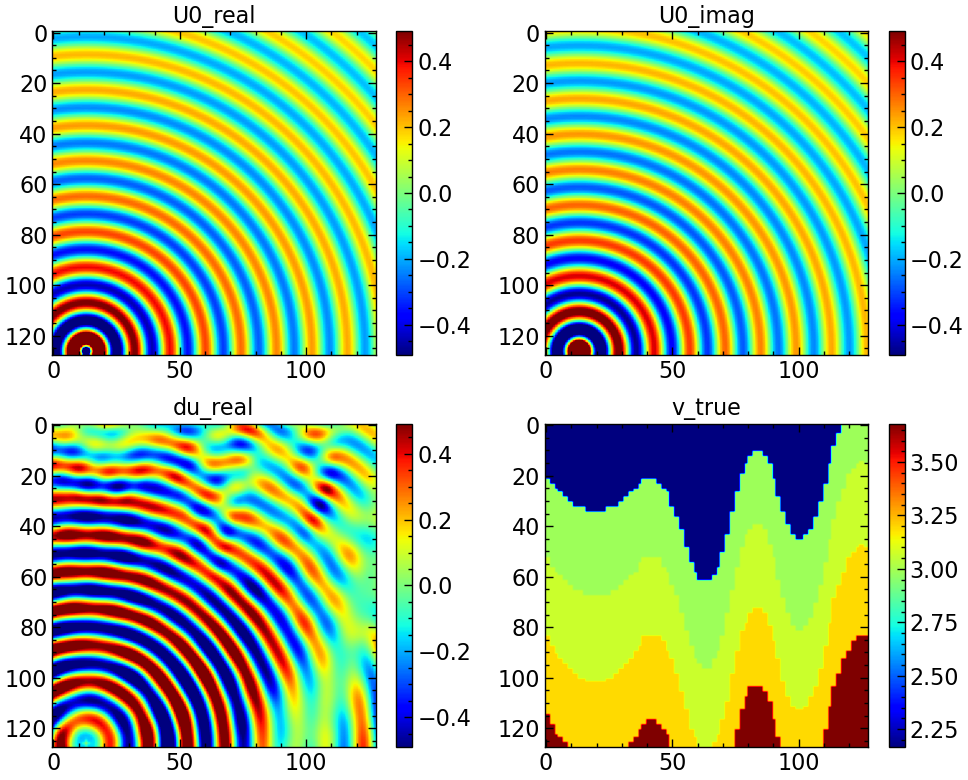

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个包含2行2列的子图布局
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
vm = np.percentile(data_sample[q,0], 99)

# 在第一个子图上绘制 u0_real
im1 = axs[0, 0].imshow(data_sample[q,0], vmin=-vm, vmax=vm, cmap='jet')
axs[0, 0].set_title("U0_real")
fig.colorbar(im1, ax=axs[0, 0])  # 添加 colorbar

# 在第二个子图上绘制 du_real_pred
im2 = axs[0, 1].imshow(data_sample[q,1], vmin=-vm, vmax=vm, cmap='jet')
axs[0, 1].set_title("U0_imag")
fig.colorbar(im2, ax=axs[0, 1])  # 添加 colorbar

# 在第三个子图上绘制 du_real
im3 = axs[1, 0].imshow(label[q,0], vmin=-vm, vmax=vm, cmap='jet')
axs[1, 0].set_title('du_real')
fig.colorbar(im3, ax=axs[1, 0])  # 添加 colorbar

im4 = axs[1, 1].imshow(data_sample[q,2], cmap='jet')
axs[1, 1].set_title('v_true')
fig.colorbar(im4, ax=axs[1, 1])  # 添加 colorbar
# 调整布局，避免子图之间重叠
plt.tight_layout()

In [137]:
# inputs[0,0].min(),inputs[0,0].max(),inputs[0,0].mean(),inputs[0,0].std()

In [138]:
inputs = torch.tensor(data_sample[q][:3])
print(inputs.shape)
model_network=model_network.to(device)
inputs=inputs.unsqueeze(0).to(torch.float32)
print(inputs.shape)
print(inputs.dtype)
y_hat = model_network(inputs[:,:3].to(device))

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
torch.float32


In [139]:
outputs=y_hat.squeeze().cpu().detach().numpy()
print(outputs.shape)

(2, 128, 128)


(128, 128)
(128, 128)


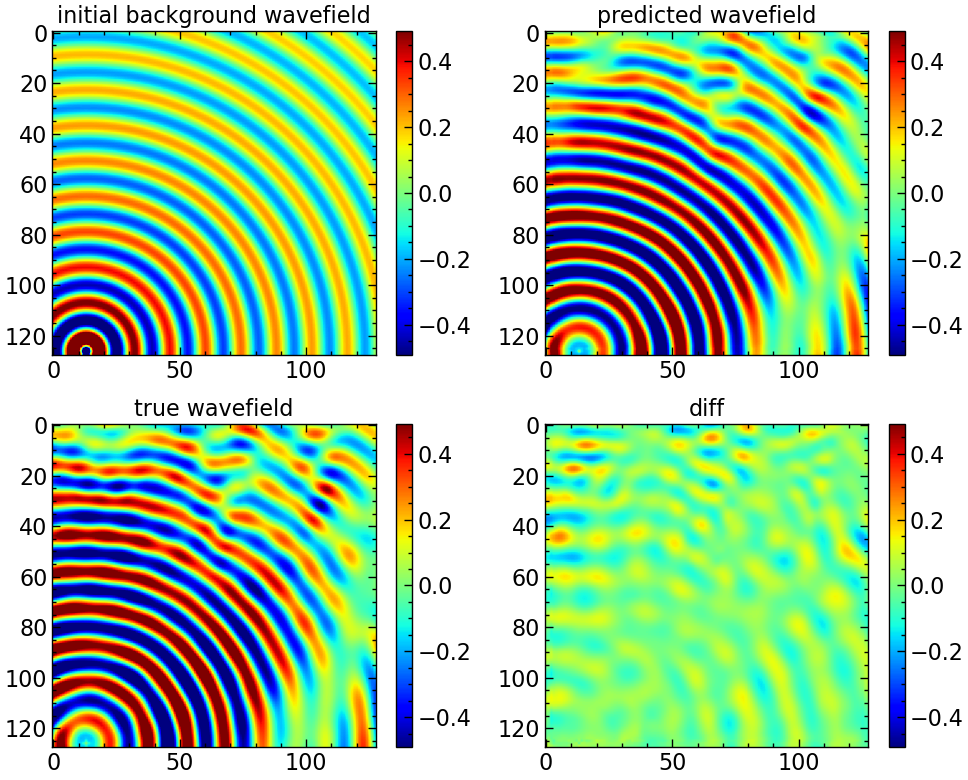

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个包含2行2列的子图布局
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
vm = np.percentile(inputs[0,0], 99)

# 在第一个子图上绘制 u0_real
im1 = axs[0, 0].imshow(inputs[0,0], vmin=-vm, vmax=vm, cmap='jet')
axs[0, 0].set_title("initial background wavefield")
fig.colorbar(im1, ax=axs[0, 0])  # 添加 colorbar

# 在第二个子图上绘制 du_real_pred
im2 = axs[0, 1].imshow(outputs[0], vmin=-vm, vmax=vm, cmap='jet')
axs[0, 1].set_title("predicted wavefield")
fig.colorbar(im2, ax=axs[0, 1])  # 添加 colorbar

# 在第三个子图上绘制 du_real
im3 = axs[1, 0].imshow(label[q,0], vmin=-vm, vmax=vm, cmap='jet')
axs[1, 0].set_title('true wavefield')
fig.colorbar(im3, ax=axs[1, 0])  # 添加 colorbar
print(label[q,0].shape)
print(outputs[0].shape)
# 在第四个子图上绘制 du_real_diff
im4 = axs[1, 1].imshow(label[q,0]-outputs[0], vmin=-vm, vmax=vm, cmap='jet')
axs[1, 1].set_title('diff')
fig.colorbar(im4, ax=axs[1, 1])  # 添加 colorbar

# 调整布局，避免子图之间重叠
plt.tight_layout()

In [141]:
# 计算两个数组的二范数
import torch.nn as nn
y_true = torch.tensor(label[q,0]).to(device)
y_pred = torch.tensor(outputs[0]).to(device)
# 定义 MSELoss 函数
mse_loss = nn.MSELoss()

# 计算 MSE 损失
loss = mse_loss(y_pred, y_true)
print(f'MSE Loss: {loss.item()}')  # 输出：MSE Loss: 0.375

MSE Loss: 0.004544622649880859


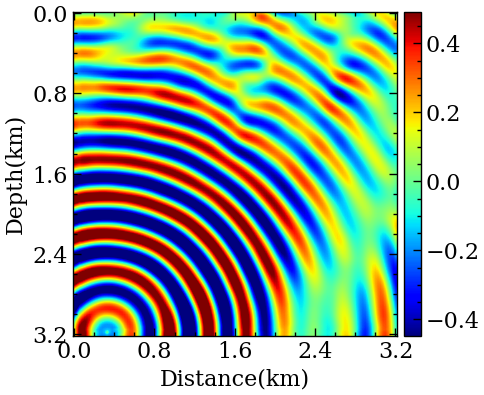

In [145]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8,4))
#model_inver=init_v.detach().cpu().numpy().squeeze()
m_vmin, m_vmax=np.percentile(inputs[0,0], [1,99]) 
im=plt.imshow(outputs[0], vmin=m_vmin, vmax=m_vmax, cmap='jet', interpolation="bilinear")
colorbar=plt.colorbar(im, shrink=1, pad=0.01)  # 调整shrink和pad参数
# colorbar.set_label("km/s", fontsize=14)
# colorbar.ax.tick_params(labelsize=12)  # Set the font size to 10
# Plot horizon with unique colors
cmap = plt.get_cmap('tab20')

# Plot horizon_initial with corresponding colors
# for i, (x, y) in enumerate(zip(inverse_x,inverse_z)):
#     color = color_map[i % len(color_map)]  # Ensures color cycling if horizon_initial is longer than color_map
#     plt.scatter(x, y, color=color, s=50, marker='o')
    
    
x_ticks = np.linspace(0, data_sample[q,2,...].shape[1]-1, 5)
x_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
y_ticks = np.linspace(0, data_sample[q,2,...].shape[0]-1, 5)
y_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
plt.tight_layout()
plt.xticks(x_ticks, x_label)
plt.yticks(y_ticks, y_label)
plt.xlabel("Distance(km)")
plt.ylabel("Depth(km)")
plt.savefig("/home/max0b/cno/seg2025/plot/8hz_scat.pdf",dpi=500)

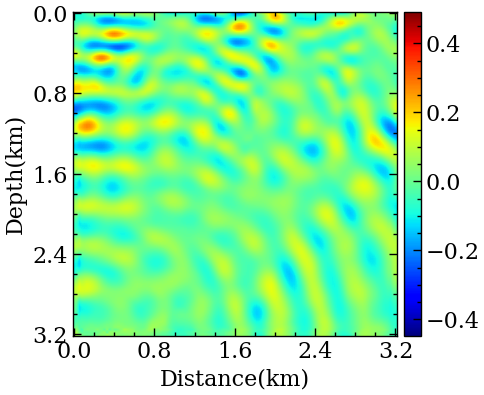

In [146]:

plt.figure(figsize=(8,4))
#model_inver=init_v.detach().cpu().numpy().squeeze()
m_vmin, m_vmax=np.percentile(inputs[0,0], [1,99]) 
im=plt.imshow(label[q,0]-outputs[0], vmin=m_vmin, vmax=m_vmax, cmap='jet', interpolation="bilinear")
colorbar=plt.colorbar(im, shrink=1, pad=0.01)  # 调整shrink和pad参数
# colorbar.set_label("km/s", fontsize=14)
# colorbar.ax.tick_params(labelsize=12)  # Set the font size to 10
# Plot horizon with unique colors
cmap = plt.get_cmap('tab20')

# Plot horizon_initial with corresponding colors
# for i, (x, y) in enumerate(zip(inverse_x,inverse_z)):
#     color = color_map[i % len(color_map)]  # Ensures color cycling if horizon_initial is longer than color_map
#     plt.scatter(x, y, color=color, s=50, marker='o')
    
    
x_ticks = np.linspace(0, data_sample[q,2,...].shape[1]-1, 5)
x_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
y_ticks = np.linspace(0, data_sample[q,2,...].shape[0]-1, 5)
y_label = [f'{num:.1f}' for num in np.linspace(0, 3.2, 5)]
plt.tight_layout()
plt.xticks(x_ticks, x_label)
plt.yticks(y_ticks, y_label)
plt.xlabel("Distance(km)")
plt.ylabel("Depth(km)")
plt.savefig("/home/max0b/cno/seg2025/plot/8hz_scat_diff.pdf",dpi=500)